Тетрадь проверки гипотез

In [2]:
# импорт необходимых и тестируемых библиотек
import base64
from datetime import date
from uuid import uuid4
from io import BytesIO
import json
from pprint import pprint
from os import listdir, mkdir
from os.path import isfile, join
from shutil import copy

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from nifti_tools import (create_bitmap_mask,
                         get_data_from_nifti_file,
                         convert_nifti_to_4ch,
                         create_bitmap_mask,
                         create_bitmap_slice,
                         create_training_dataset_file,
                         get_mask_segmentation_counts)


In [15]:
%%time
# тест получения данных без транспонирования
data = get_data_from_nifti_file('datasets/Task02_Heart/imagesTr/la_003.nii.gz')
mask = get_data_from_nifti_file('datasets/Task02_Heart/labelsTr/la_003.nii.gz')


CPU times: user 591 ms, sys: 256 ms, total: 847 ms
Wall time: 962 ms


In [16]:
%%time
# тест получения данных с транспонированием
data_t = get_data_from_nifti_file('datasets/Task02_Heart/imagesTr/la_003.nii.gz', transponded=True)
mask_t = get_data_from_nifti_file('datasets/Task02_Heart/labelsTr/la_003.nii.gz', transponded=True)

CPU times: user 588 ms, sys: 247 ms, total: 835 ms
Wall time: 971 ms


In [17]:
%%time
layers_count = data.shape[2]
transpored_data = data.T
transpored_mask = mask.T

CPU times: user 561 µs, sys: 16.7 ms, total: 17.2 ms
Wall time: 19.7 ms


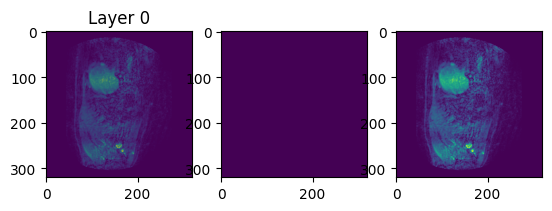

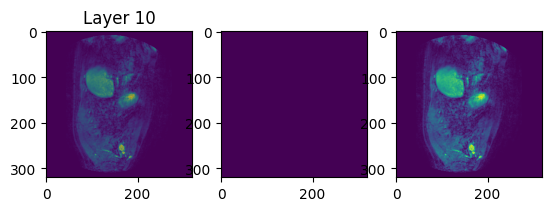

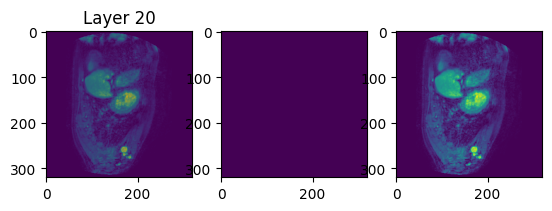

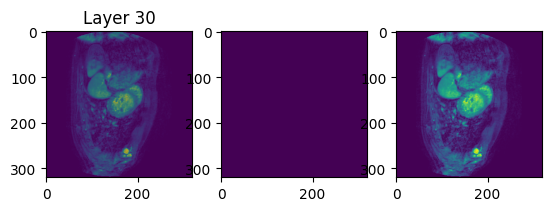

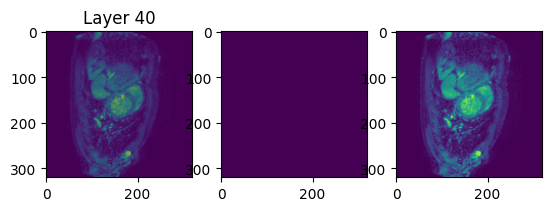

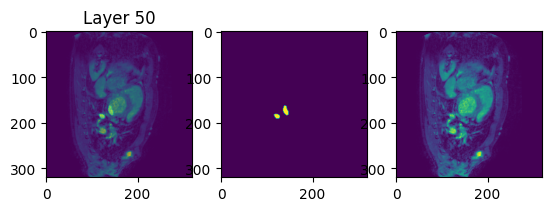

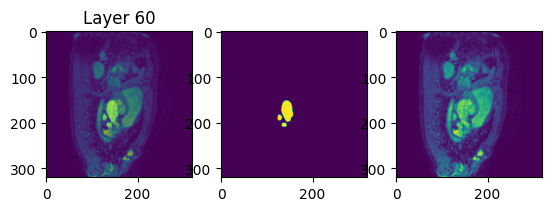

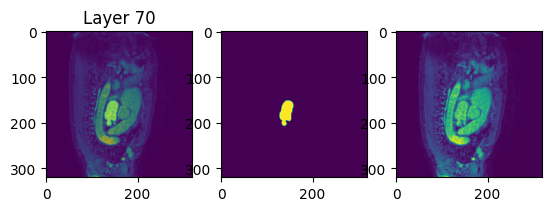

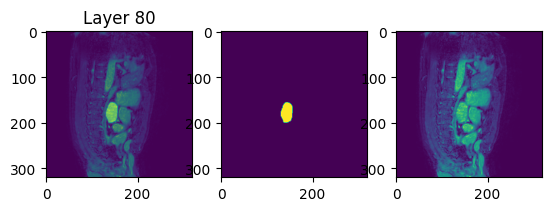

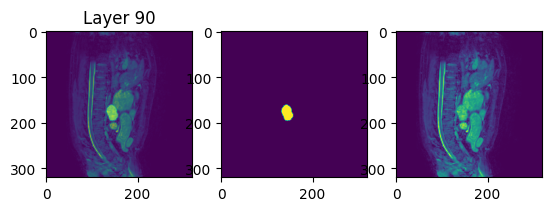

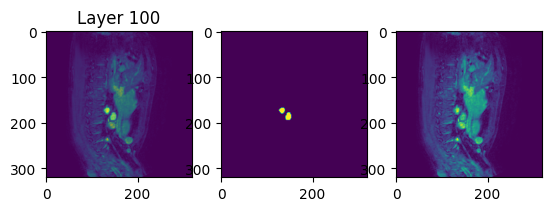

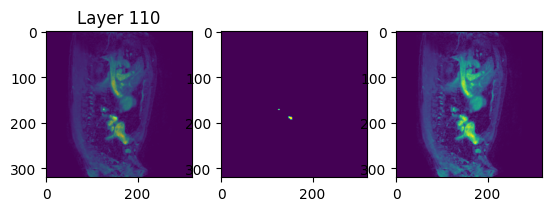

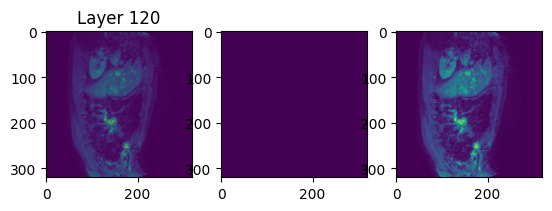

In [30]:
# Визуализация "сырых" данных
for i in range(layers_count):
    if i%10 == 0:
        fig, axs = plt.subplots(1,3)
        axs[0].set_title(f'Layer {i}')
        axs[0].imshow(transpored_data[i])
        axs[0].imshow(transpored_mask[i], alpha=0.3)
        axs[1].imshow(transpored_mask[i])
        axs[2].imshow(transpored_data[i])
        plt.show()


In [19]:
# получение максимального значения элемента в матрице исходных данных
print(transpored_data.max())

1999.0


In [20]:
# показываем первую "картинку"
im = Image.fromarray(transpored_mask[0])
im.show()

In [21]:
# размерность картинки
transpored_mask[60].shape

(320, 320)

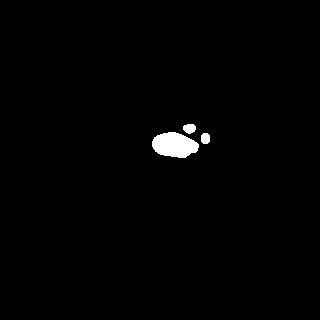

In [22]:
# тест генератора монохромного bitmap маски
create_bitmap_mask(transpored_mask[60])

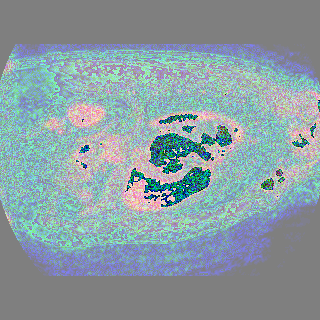

In [23]:
# тест генератора-кодера bitmap снимка/среза
create_bitmap_slice(transpored_data[60])

In [24]:
# тест конвертора из значения элемента nifti в RGB bitmap с альфаканалом
convert_nifti_to_4ch(1234)

(51, 76, 102, 255)

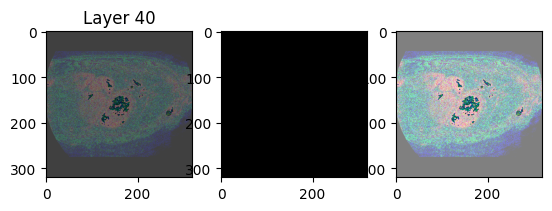

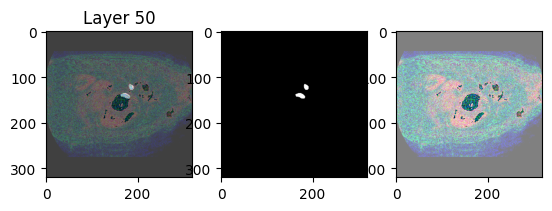

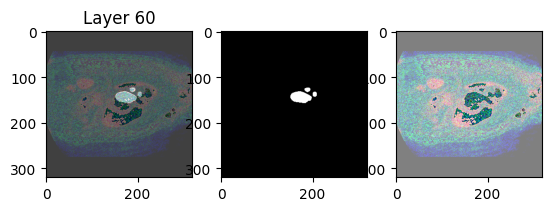

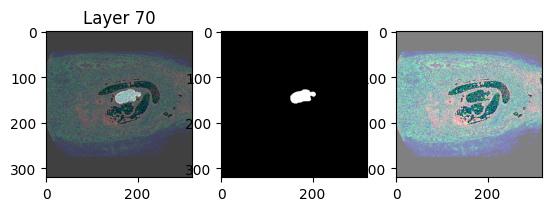

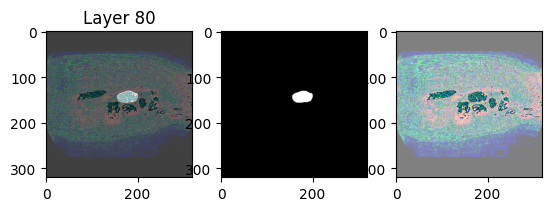

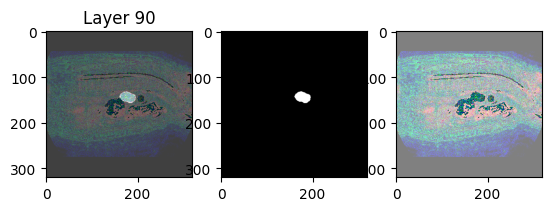

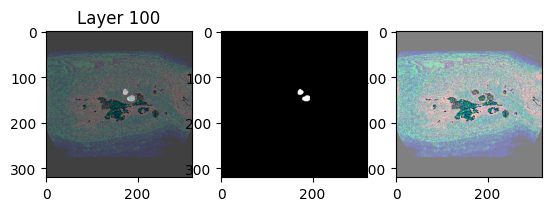

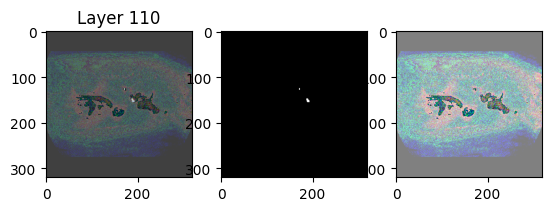

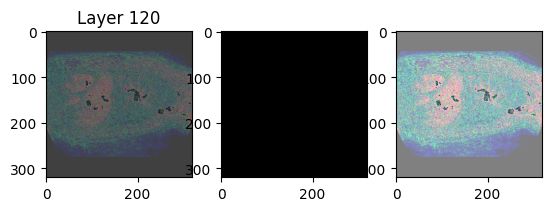

In [31]:
# Визуализация "предобработанных" данных
for i in range(40,transpored_data.shape[0]):
    if i%10 == 0:
        fig, axs = plt.subplots(1,3)
        axs[0].set_title(f'Layer {i}')
        axs[0].imshow(create_bitmap_slice(transpored_data[i]))
        axs[0].imshow(create_bitmap_mask(transpored_mask[i]),alpha=0.5)
        axs[1].imshow(create_bitmap_mask(transpored_mask[i]))
        axs[2].imshow(create_bitmap_slice(transpored_data[i]))
        plt.show()

In [26]:
# тест наивной реализации конвертора слой + маска -> bitmap слоя и bitmap маски
create_training_dataset_file(dataset_root_folder = 'datasets/img',
                              data = transpored_data[60],
                              labels= transpored_mask[60],
                              caption='la_003')

In [27]:
# вариации генерации данных
def create_training_dataset_file_json1(dataset_root_folder: str, data: np.array, labels: np.array, caption: str):
    """Create bitmap files for training dataset:
    dataset_root_folder/caption_image.bmp and dataset_root_folder/caption_mask.bmp 

    Args:
        dataset_root_folder (str): folser for storing training dataset
        data (np.array): X
        labels (np.array): y
        caption (str): caption for files
    """
    image = create_bitmap_slice(data)
    mask = create_bitmap_mask(labels)
    image.save(f'{dataset_root_folder}/{caption}_image.bmp')
    buffered = BytesIO()
    mask.save(fp=buffered, format='BMP')
    
    mask_json = dict()
    mask_json['segmentation_mask'] = str(base64.b64encode(buffered.getvalue()))
    mask_json['class_map'] = {"0":"other", "1":"left atrium"}
    mask_json['image'] = {'width': mask.width, 'height': mask.height}
    
    with open(f'{dataset_root_folder}/{caption}_image.json','w') as mask_file:
        json.dump(mask_json, mask_file)
    
create_training_dataset_file_json1(dataset_root_folder = 'datasets/img',
                              data = transpored_data[60],
                              labels= transpored_mask[60],
                              caption='la_003')

In [33]:
%%time
# Проверка генератора маски для COCO формата
a = [[0, 0, 0, 0],
     [0, 1, 1, 0],
     [0, 0, 1, 0],
     [0, 0, 0, 0]
     ]
a = np.array(a)



print(get_mask_segmentation_counts(transpored_mask[60], 0))
print(get_mask_segmentation_counts(transpored_mask[60], 1))

img = Image.open('datasets/img/la_007_layer60_mask.bmp')
iarr = np.int0(img)
print(get_mask_segmentation_counts(iarr, 1))

[0, 48781, 6, 312, 10, 308, 13, 307, 15, 304, 16, 303, 18, 302, 19, 301, 19, 300, 21, 299, 21, 299, 21, 298, 22, 298, 23, 297, 23, 297, 23, 297, 23, 296, 24, 296, 24, 296, 24, 296, 25, 295, 25, 295, 25, 295, 25, 295, 25, 296, 24, 296, 24, 296, 25, 296, 24, 296, 24, 296, 24, 297, 23, 288, 4, 5, 23, 287, 6, 5, 22, 287, 7, 4, 22, 287, 8, 4, 20, 287, 9, 4, 19, 288, 10, 4, 18, 288, 10, 4, 17, 289, 10, 5, 15, 290, 9, 6, 14, 291, 9, 7, 13, 291, 8, 8, 13, 292, 7, 9, 12, 293, 4, 12, 11, 309, 10, 311, 8, 313, 4, 947, 7, 312, 9, 310, 11, 309, 11, 309, 11, 309, 11, 309, 11, 310, 9, 312, 7, 35378]
[48781, 6, 312, 10, 308, 13, 307, 15, 304, 16, 303, 18, 302, 19, 301, 19, 300, 21, 299, 21, 299, 21, 298, 22, 298, 23, 297, 23, 297, 23, 297, 23, 296, 24, 296, 24, 296, 24, 296, 25, 295, 25, 295, 25, 295, 25, 295, 25, 296, 24, 296, 24, 296, 25, 296, 24, 296, 24, 296, 24, 297, 23, 288, 4, 5, 23, 287, 6, 5, 22, 287, 7, 4, 22, 287, 8, 4, 20, 287, 9, 4, 19, 288, 10, 4, 18, 288, 10, 4, 17, 289, 10, 5, 15, 290,

In [3]:
%%time


def preparer_COCO_dataset_two_cat(folder: str,
                                  slice_postfix: str = '_image.bmp',
                                  mask_postfix: str = '_mask.bmp') -> [dict, list]:
    """Create a dataset with annotation from slice bitmap and mask bitmap files
    with one type of instance: is or not

    Args:
        folder (str): path to folder with bitmaps
        slice_postfix (str, optional): filename postfix of slice bitmaps. Defaults to '_image.bmp'.
        mask_postfix (str, optional): filename postfix of mask bitmaps. Defaults to '_mask.bmp'.
    """
    all_files = [f for f in listdir(folder) if isfile(join(folder, f))]
    mask_files = list()
    slice_files = list()
    ids = dict()
    for file in all_files:
        if slice_postfix in file:
            slice_files.append(file)
            ids[file.replace(slice_postfix, '').replace(
                mask_postfix, '')] = uuid4().int
        elif mask_postfix in file:
            mask_files.append(file)
            ids[file.replace(slice_postfix, '').replace(
                mask_postfix, '')] = uuid4().int
    all_files.clear()

    annotation_section = list()
    images_section = list()

    for file in mask_files:
        img = Image.open(f'{folder}/{file}')
        img_array = np.int0(img)

        instance_pixel_count = int(np.sum(img_array))

        if instance_pixel_count == 0:
            # TODO: внести запись что только фон
            continue

        # фон
        counts_not_for_instance = get_mask_segmentation_counts(img_array, 0)
        record = dict()
        record['segmentation'] = dict()
        record['segmentation']['counts'] = counts_not_for_instance
        record['segmentation']['size'] = [*img_array.shape]
        record['area'] = int(img_array.shape[0] *
                             img_array.shape[1] - instance_pixel_count)
        record['iscrowd'] = 1
        record['image_id'] = int(
            ids[file.replace(slice_postfix, '').replace(mask_postfix, '')])
        record['category_id'] = 0
        record['mask_id'] = uuid4().int
        annotation_section.append(record)
        # маска
        counts_for_instance = get_mask_segmentation_counts(img_array, 1)
        record = dict()
        record['segmentation'] = dict()
        record['segmentation']['counts'] = counts_for_instance
        record['segmentation']['size'] = [*img_array.shape]
        record['area'] = instance_pixel_count
        record['iscrowd'] = 1
        record['image_id'] = ids[file.replace(
            slice_postfix, '').replace(mask_postfix, '')]
        record['category_id'] = 0
        record['mask_id'] = uuid4().int
        annotation_section.append(record)
        

    for file in slice_files:
        img = Image.open(f'{folder}/{file}')
        img_array = np.int0(img)
        image_pixel_count = int(np.sum(img_array))
        record = dict()
        record['license'] = 1
        record['file_name'] = file
        record['height'], record['width'], _ = img_array.shape
        record['id'] = int(
            ids[file.replace(slice_postfix, '').replace(mask_postfix, '')])
        images_section.append(record)
       

    dataset_annotation = dict()
    dataset_annotation['info'] = [
        {
            "description": "Left atrium segmentation from King's College London nifti dataset",
            "url": "",
            "version": "1.0",
            "year": int(date.today().strftime("%Y")),
            "contributor": "Alex Shkil",
            "date_created": date.today().strftime("%Y/%m/%d")
        }
    ]
    dataset_annotation['licenses'] = [
        {
            "licenses": [
                {
                    "url": "https://creativecommons.org/licenses/by-sa/4.0/",
                    "id": 1,
                    "name": "Attribution-ShareAlike 4.0 International (CC BY-SA 4.0)"
                }
            ]
        }
    ]
    dataset_annotation['images'] = images_section
    dataset_annotation['annotations'] = annotation_section
    dataset_annotation['categories'] = [
        {
            "supercategory": "heart",
            "id": 0,
            "name": "not a left atrium"
        },
        {
            "supercategory": "heart",
            "id": 1,
            "name": "left atrium"
        }
    ]

    return dataset_annotation, slice_files


folder = 'datasets/img/test'
dataset_annotation, slice_files = preparer_COCO_dataset_two_cat(folder=folder)
try:
    mkdir(join(folder, 'COCO'))
except FileExistsError:
    pass
with open(folder+'/COCO/description.json', 'w') as jf:
    json.dump(dataset_annotation, jf)

for file in slice_files:
    copy(folder+'/'+file, folder+'/COCO/'+file)



CPU times: user 128 ms, sys: 10.6 ms, total: 139 ms
Wall time: 151 ms


In [100]:
import uuid
str(uuid.uuid4().int)

'12512114866790136506004522593944156097'